DATA PREPROCESSING


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2012-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Temp_C            8784 non-null   float64
 1   Dew Point Temp_C  8784 non-null   float64
 2   Rel Hum_%         8784 non-null   int64  
 3   Wind Speed_km/h   8784 non-null   int64  
 4   Visibility_km     8784 non-null   float64
 5   Press_kPa         8784 non-null   float64
 6   Weather           8784 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 549.0+ KB
None
            Temp_C  Dew Point Temp_C    Rel Hum_%  Wind Speed_km/h  \
count  8784.000000       8784.000000  8784.000000      8784.000000   
mean      8.798144          2.555294    67.431694        14.945469   
std      11.687883         10.883072    16.918881         8.688696   
min     -23.300000        -28.500000    18.000000         0.000000   
25%       0.1000

<ipython-input-3-c0baed0e6475>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


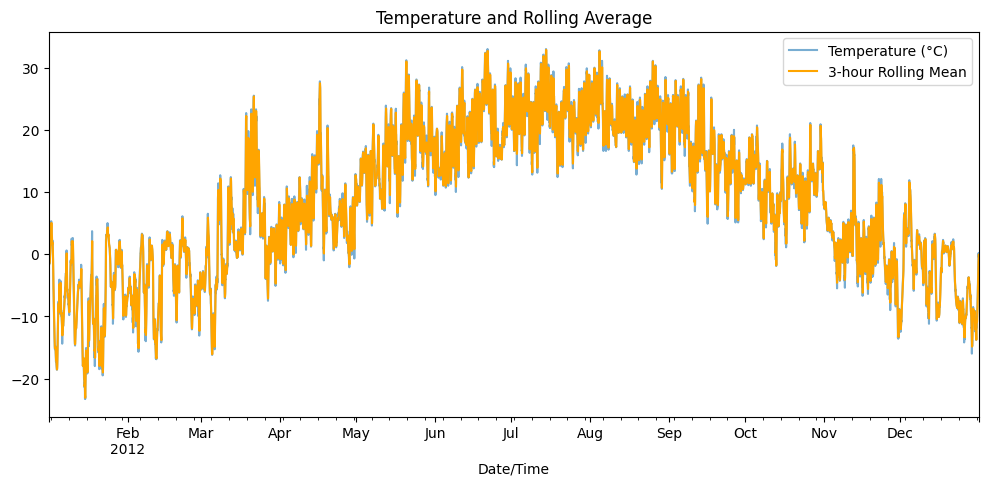

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the dataset
df = pd.read_csv('Weather_Data.csv', parse_dates=['Date/Time'])

# 2. Set Date/Time as index
df.set_index('Date/Time', inplace=True)

# 3. Basic inspection
print(df.info())
print(df.describe())

# 4. Rename columns for easier access (optional)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# 5. Check for missing values
print(df.isnull().sum())

# 6. Fill or remove missing values
# Option A: Forward fill
df.fillna(method='ffill', inplace=True)

# Option B: Drop rows with NaNs (less preferred)
# df.dropna(inplace=True)

# 7. Convert categorical "weather" column into numeric categories
df['weather_cat'] = df['weather'].astype('category').cat.codes

# 8. Feature Engineering
# Example: Rolling mean (3-hour average temperature)
# Changed 'Temp_C' to 'temp_c' after renaming
df['temp_roll_3h'] = df['temp_c'].rolling(window=3).mean()

# Lag feature (1 hour ago temp)
# Changed 'Temp_C' to 'temp_c' after renaming
df['temp_lag_1h'] = df['temp_c'].shift(1)

# Extract time-based features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# 9. Drop rows with any NaNs created due to lag/rolling
df.dropna(inplace=True)

# 10. Plotting to visualize cleaned temperature trend
plt.figure(figsize=(12,5))
# Changed 'Temp_C' to 'temp_c' after renaming
df['temp_c'].plot(label='Temperature (°C)', alpha=0.6)
df['temp_roll_3h'].plot(label='3-hour Rolling Mean', color='orange')
plt.legend()
plt.title("Temperature and Rolling Average")
plt.show()

EXPLORATORY DATA ANALYSIS


In [4]:
print(df.describe())


            temp_c  dew_point_temp_c    rel_hum_%  wind_speed_km/h  \
count  8782.000000       8782.000000  8782.000000      8782.000000   
mean      8.800558          2.556741    67.427351        14.947962   
std      11.688119         10.883889    16.918359         8.688115   
min     -23.300000        -28.500000    18.000000         0.000000   
25%       0.100000         -5.900000    56.000000         9.000000   
50%       9.300000          3.300000    68.000000        13.000000   
75%      18.800000         11.800000    81.000000        20.000000   
max      33.000000         24.400000   100.000000        83.000000   

       visibility_km    press_kpa  weather_cat  temp_roll_3h  temp_lag_1h  \
count    8782.000000  8782.000000  8782.000000   8782.000000  8782.000000   
mean       27.668925   101.051581    14.584263      8.800361     8.800353   
std        12.620636     0.844096    11.493165     11.663957    11.688289   
min         0.200000    97.520000     0.000000    -23.100000 

TIME SERIES PLOT-TEMPERATURE OVER TIME

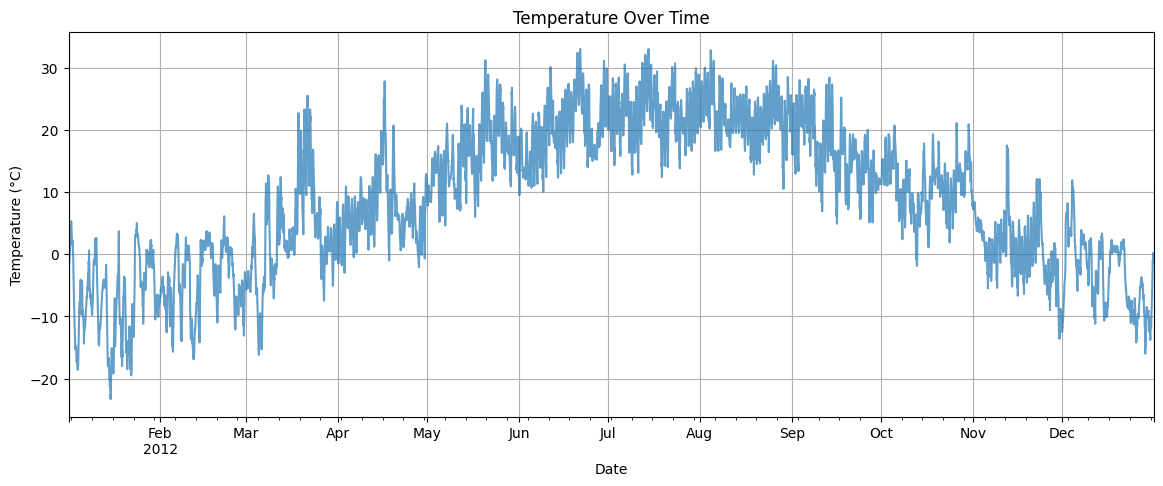

In [6]:
plt.figure(figsize=(14,5))
# Changed 'temperature_°c' to 'temp_c' to match the renamed column
df['temp_c'].plot(alpha=0.7)
plt.title("Temperature Over Time")
plt.ylabel("Temperature (°C)")
plt.xlabel("Date")
plt.grid()
plt.show()


Decompose Time Series (Trend, Seasonality, Residual)

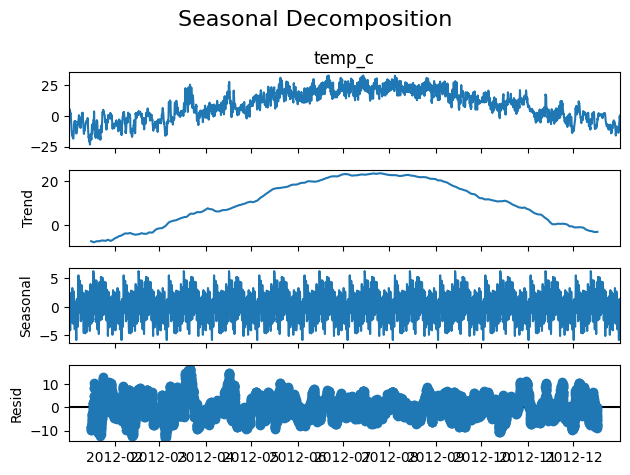

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['temp_c'], model='additive', period=24*30)  # approx 1 month
result.plot()
plt.suptitle("Seasonal Decomposition", fontsize=16)
plt.tight_layout()
plt.show()


Temperature by Hour of Day


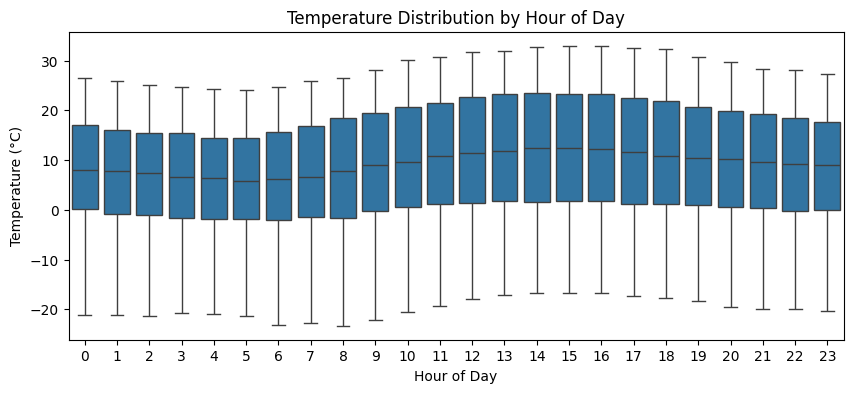

In [10]:
plt.figure(figsize=(10,4))
sns.boxplot(x='hour', y='temp_c', data=df)
plt.title("Temperature Distribution by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Temperature (°C)")
plt.show()


 Temperature by Month

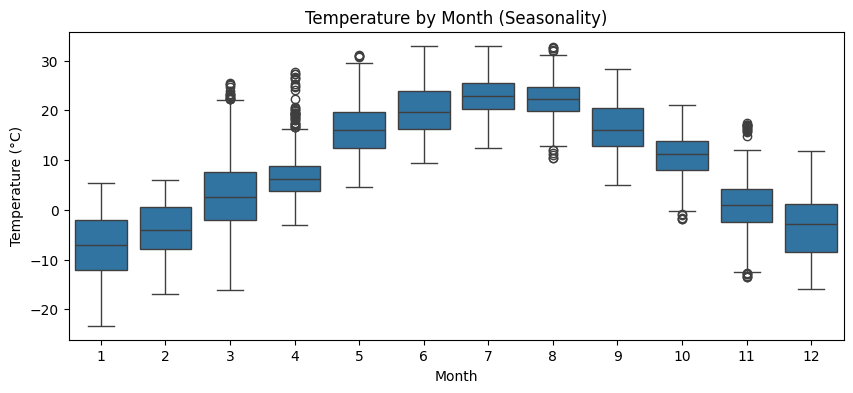

In [11]:
plt.figure(figsize=(10,4))
sns.boxplot(x='month', y='temp_c', data=df)
plt.title("Temperature by Month (Seasonality)")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.show()


Correlation Heatmap

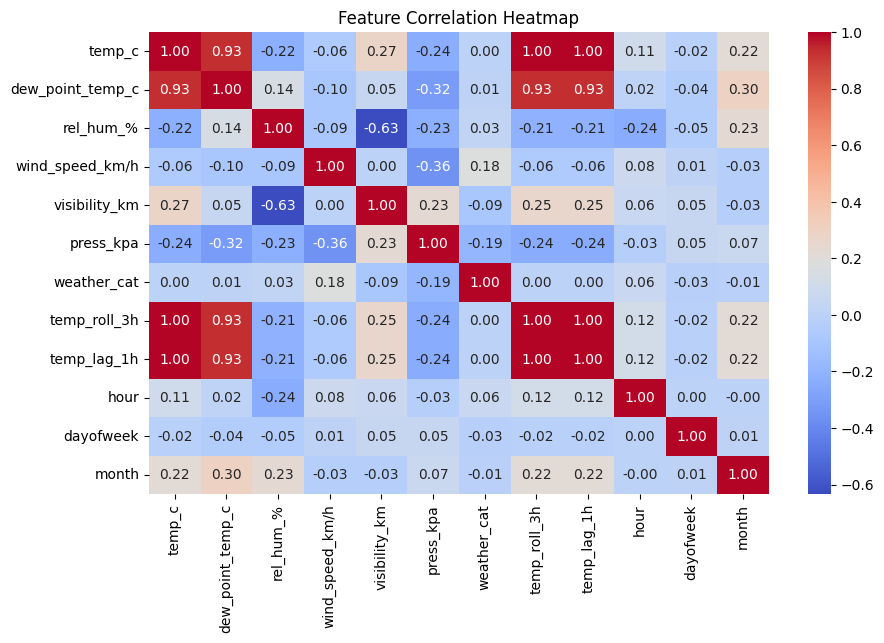

In [13]:
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=np.number)

plt.figure(figsize=(10,6))
# Calculate correlation on the numeric DataFrame
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Weather Type Counts (Categorical)

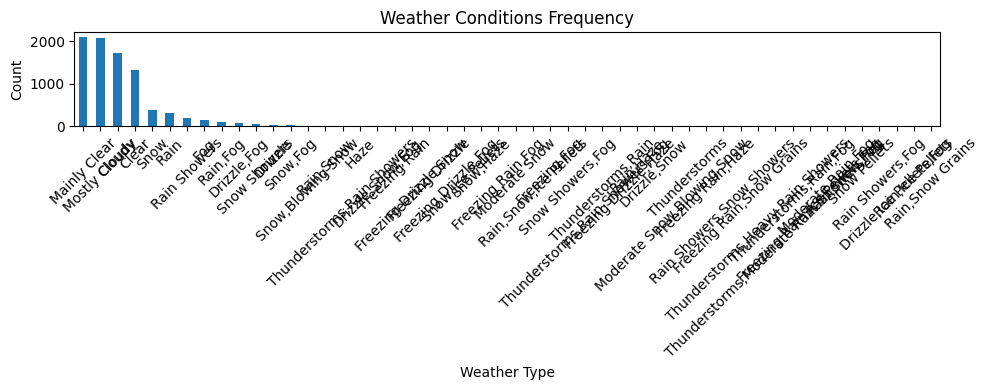

In [14]:
plt.figure(figsize=(10,4))
df['weather'].value_counts().plot(kind='bar')
plt.title("Weather Conditions Frequency")
plt.xlabel("Weather Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Pairplot of Selected Features

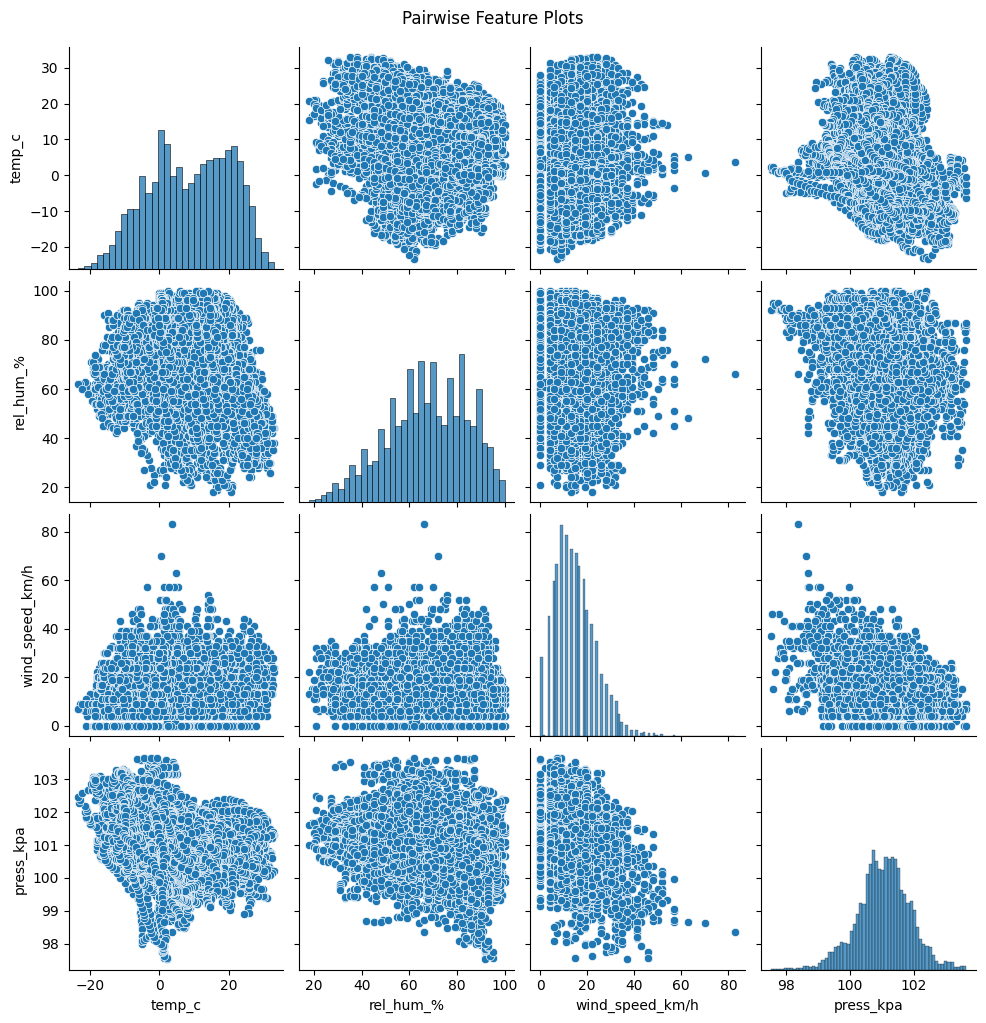

In [18]:

sns.pairplot(df[['temp_c', 'rel_hum_%', 'wind_speed_km/h', 'press_kpa']])
plt.suptitle("Pairwise Feature Plots", y=1.02)
plt.show()

Summary of EDA

| Plot/Analysis          | Insight                                |
| ---------------------- | -------------------------------------- |
| Time series            | Long-term trends                       |
| Seasonal decomposition | Seasonality & noise                    |
| Boxplots               | Daily & monthly patterns               |
| Correlation            | Relationships (e.g., temp vs humidity) |
| Weather counts         | Distribution of weather types          |




Time Series Modeling & Basic Regression

In [19]:
# Use last 30 days as test set
train = df[:-24*30]
test = df[-24*30:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (8062, 13)
Test shape: (720, 13)


Basic Linear Regression for Temperature Trend

<ipython-input-21-895325c6da86>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['time_ordinal'] = train.index.map(lambda x: x.toordinal())
<ipython-input-21-895325c6da86>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['time_ordinal'] = test.index.map(lambda x: x.toordinal())
<ipython-input-21-895325c6da86>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

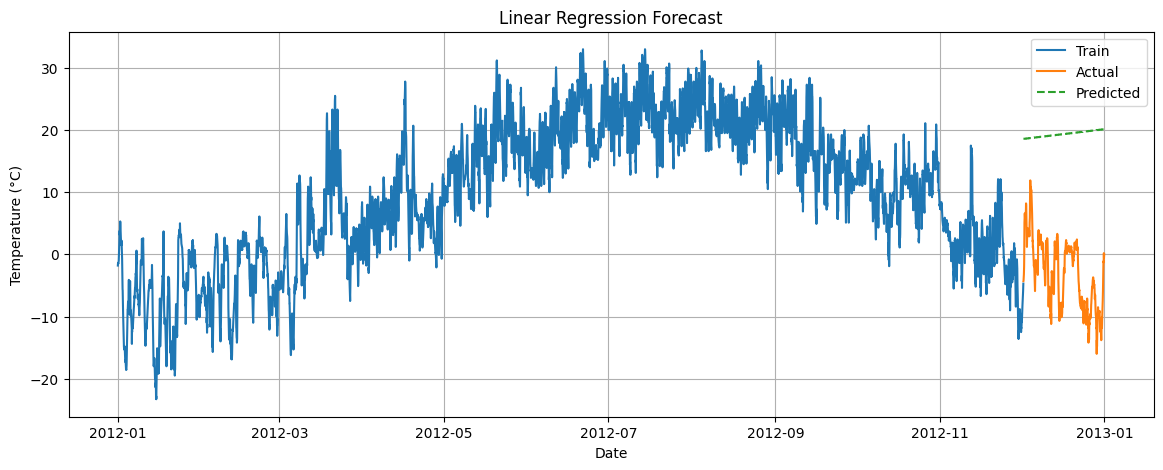

In [21]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Convert datetime index to ordinal (numerical format for regression)
train['time_ordinal'] = train.index.map(lambda x: x.toordinal())
test['time_ordinal'] = test.index.map(lambda x: x.toordinal())

# Fit the model
model = LinearRegression()
model.fit(train[['time_ordinal']], train['temp_c'])

# Predict
test['pred_temp'] = model.predict(test[['time_ordinal']])

# Plot
plt.figure(figsize=(14,5))
plt.plot(train.index, train['temp_c'], label='Train')
plt.plot(test.index, test['temp_c'], label='Actual')
plt.plot(test.index, test['pred_temp'], label='Predicted', linestyle='--')
plt.legend()
plt.title("Linear Regression Forecast")
plt.ylabel("Temperature (°C)")
plt.xlabel("Date")
plt.grid()
plt.show()


Evaluation Metrics

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Actual vs Predicted
y_true = test['temp_c']
y_pred = test['pred_temp']

# Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
bias = np.mean(y_pred - y_true)

# Print results
print("📊 Evaluation Metrics:")
print(f"MAE   (Mean Absolute Error): {mae:.2f}")
print(f"MSE   (Mean Squared Error) : {mse:.2f}")
print(f"RMSE  (Root MSE)           : {rmse:.2f}")
print(f"R² Score (Explained Var)   : {r2:.4f}")
print(f"Bias (Avg error)           : {bias:.2f}")


📊 Evaluation Metrics:
MAE   (Mean Absolute Error): 22.47
MSE   (Mean Squared Error) : 539.51
RMSE  (Root MSE)           : 23.23
R² Score (Explained Var)   : -16.2595
Bias (Avg error)           : 22.47


Prediction and Visualization

1. Make Predictions with the Trained Model,
Prediction using Linear Regression

In [34]:
from sklearn.linear_model import LinearRegression

# Convert datetime to ordinal for regression
train['time_ordinal'] = train.index.map(lambda x: x.toordinal())
test['time_ordinal'] = test.index.map(lambda x: x.toordinal())

# Fit the model
model = LinearRegression()
model.fit(train[['time_ordinal']], train['temp_c'])

<ipython-input-34-5033e475dbd0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['time_ordinal'] = train.index.map(lambda x: x.toordinal())
<ipython-input-34-5033e475dbd0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['time_ordinal'] = test.index.map(lambda x: x.toordinal())


LinearRegression()

In [35]:
test['pred_temp'] = model.predict(test[['time_ordinal']])

<ipython-input-35-db0081c7c5f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_temp'] = model.predict(test[['time_ordinal']])


In [23]:

test['pred_temp'] = model.predict(test[['time_ordinal']])


<ipython-input-23-db0081c7c5f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_temp'] = model.predict(test[['time_ordinal']])


 Predicted Results

In [37]:
print(test[['temp_c', 'pred_temp']].head())


                     temp_c  pred_temp
Date/Time                             
2012-12-02 00:00:00    -4.3  18.602367
2012-12-02 01:00:00    -4.2  18.602367
2012-12-02 02:00:00    -3.9  18.602367
2012-12-02 03:00:00    -3.5  18.602367
2012-12-02 04:00:00    -3.2  18.602367


In [38]:
test[['temp_c', 'pred_temp']].to_csv("predicted_temperatures.csv")


 2. Line Plot – Actual vs Predicted Temperature

<ipython-input-25-387b97a2089f>:13: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


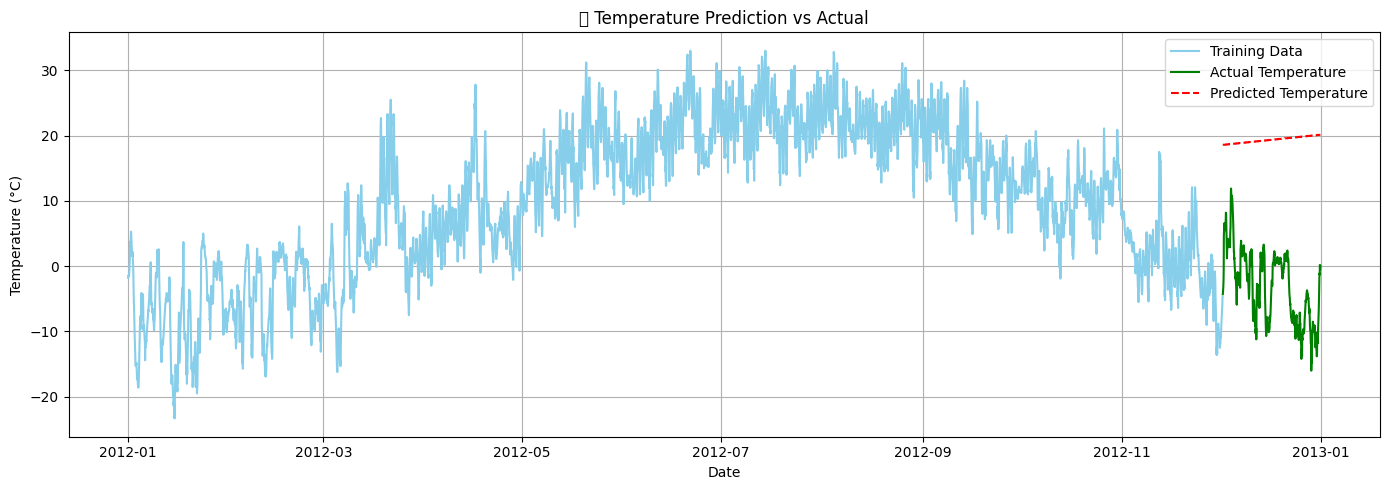

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(train.index, train['temp_c'], label='Training Data', color='skyblue')
plt.plot(test.index, test['temp_c'], label='Actual Temperature', color='green')
plt.plot(test.index, test['pred_temp'], label='Predicted Temperature', color='red', linestyle='--')

plt.title("📉 Temperature Prediction vs Actual")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Residual Plot (Error Over Time)

<ipython-input-28-287e499630f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['residuals'] = test['temp_c'] - test['pred_temp']
<ipython-input-28-287e499630f4>:10: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


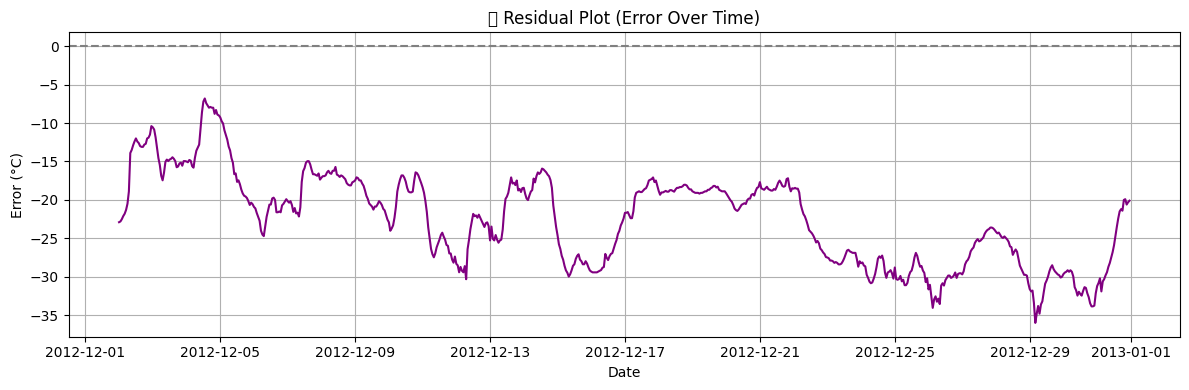

In [28]:
test['residuals'] = test['temp_c'] - test['pred_temp']

plt.figure(figsize=(12,4))
plt.plot(test.index, test['residuals'], label='Residuals', color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residual Plot (Error Over Time)")
plt.xlabel("Date")
plt.ylabel("Error (°C)")
plt.grid()
plt.tight_layout()
plt.show()


AIM:Forecast Temperature for Next 7, 30, or 90 Days using Linear Regression

 1. Convert datetime to numeric & fit model

In [40]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure datetime index
df.index = pd.to_datetime(df.index)

# Convert to ordinal for regression
df['time_ordinal'] = df.index.map(lambda x: x.toordinal())

# Train linear regression
model = LinearRegression()
model.fit(df[['time_ordinal']], df['temp_c'])


LinearRegression()

2. Forecast next 7, 30, or 90 days (hourly)

In [41]:
# Choose forecast horizon
forecast_days = 30
forecast_hours = forecast_days * 24

# Generate future timestamps
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=forecast_hours, freq='H')

# Convert to ordinal
future_ordinal = future_dates.map(lambda x: x.toordinal()).to_numpy().reshape(-1, 1)

# Predict
future_preds = model.predict(future_ordinal)

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    'Forecast': future_preds
}, index=future_dates)


<ipython-input-41-0140f31b1a86>:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=forecast_hours, freq='H')
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


 3. Plot Historical + Forecasted Temperature

<ipython-input-42-2781f10e6f06>:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


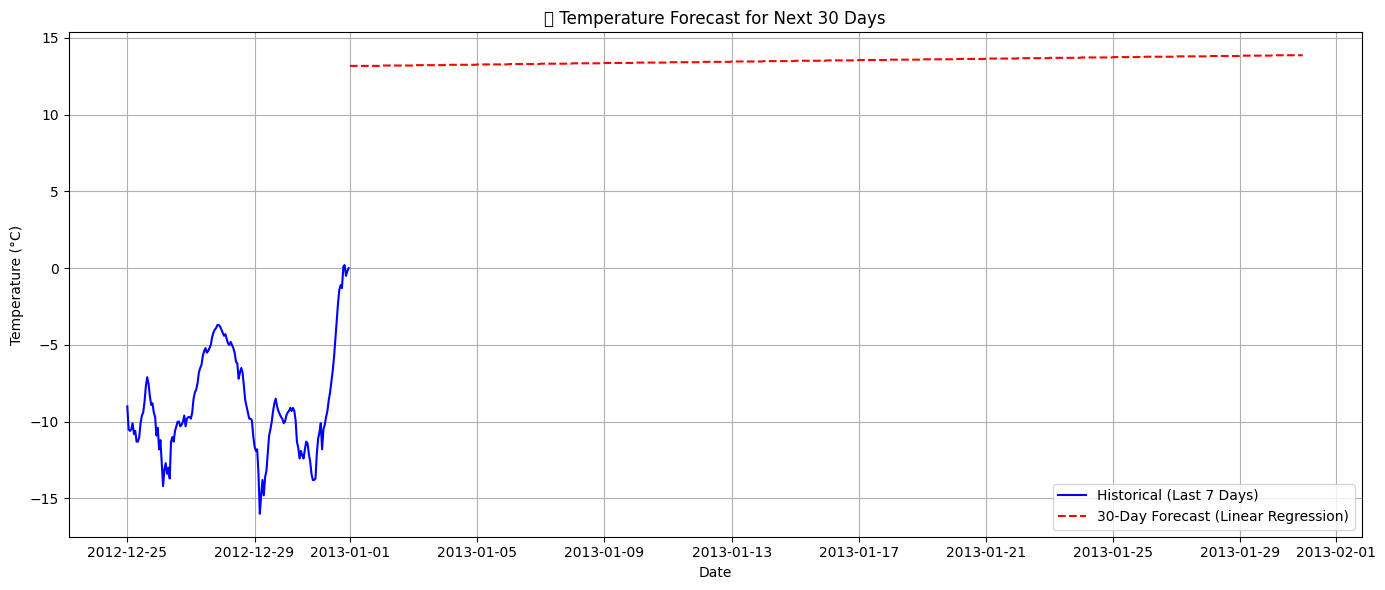

In [42]:
plt.figure(figsize=(14,6))

# Plot last 7 days of history
plt.plot(df.index[-24*7:], df['temp_c'].iloc[-24*7:], label='Historical (Last 7 Days)', color='blue')

# Forecast plot
plt.plot(forecast_df.index, forecast_df['Forecast'], label=f'{forecast_days}-Day Forecast (Linear Regression)', color='red', linestyle='--')

plt.title(f"Temperature Forecast for Next {forecast_days} Days")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Summary

Works well for trend-based predictions

Fast and interpretable

Ideal when seasonality is minimal